# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [1]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков

%matplotlib inline

Прочитаем исходные данные:

In [2]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

In [3]:
# Ваш код здесь
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Well     200 non-null    int64  
 1   Por      200 non-null    float64
 2   Perm     200 non-null    float64
 3   AI       200 non-null    float64
 4   Brittle  200 non-null    float64
 5   TOC      200 non-null    float64
 6   VR       200 non-null    float64
 7   Prod     200 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 12.6 KB


In [4]:
types = data.dtypes
features = list(types.index)
features

['Well', 'Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']

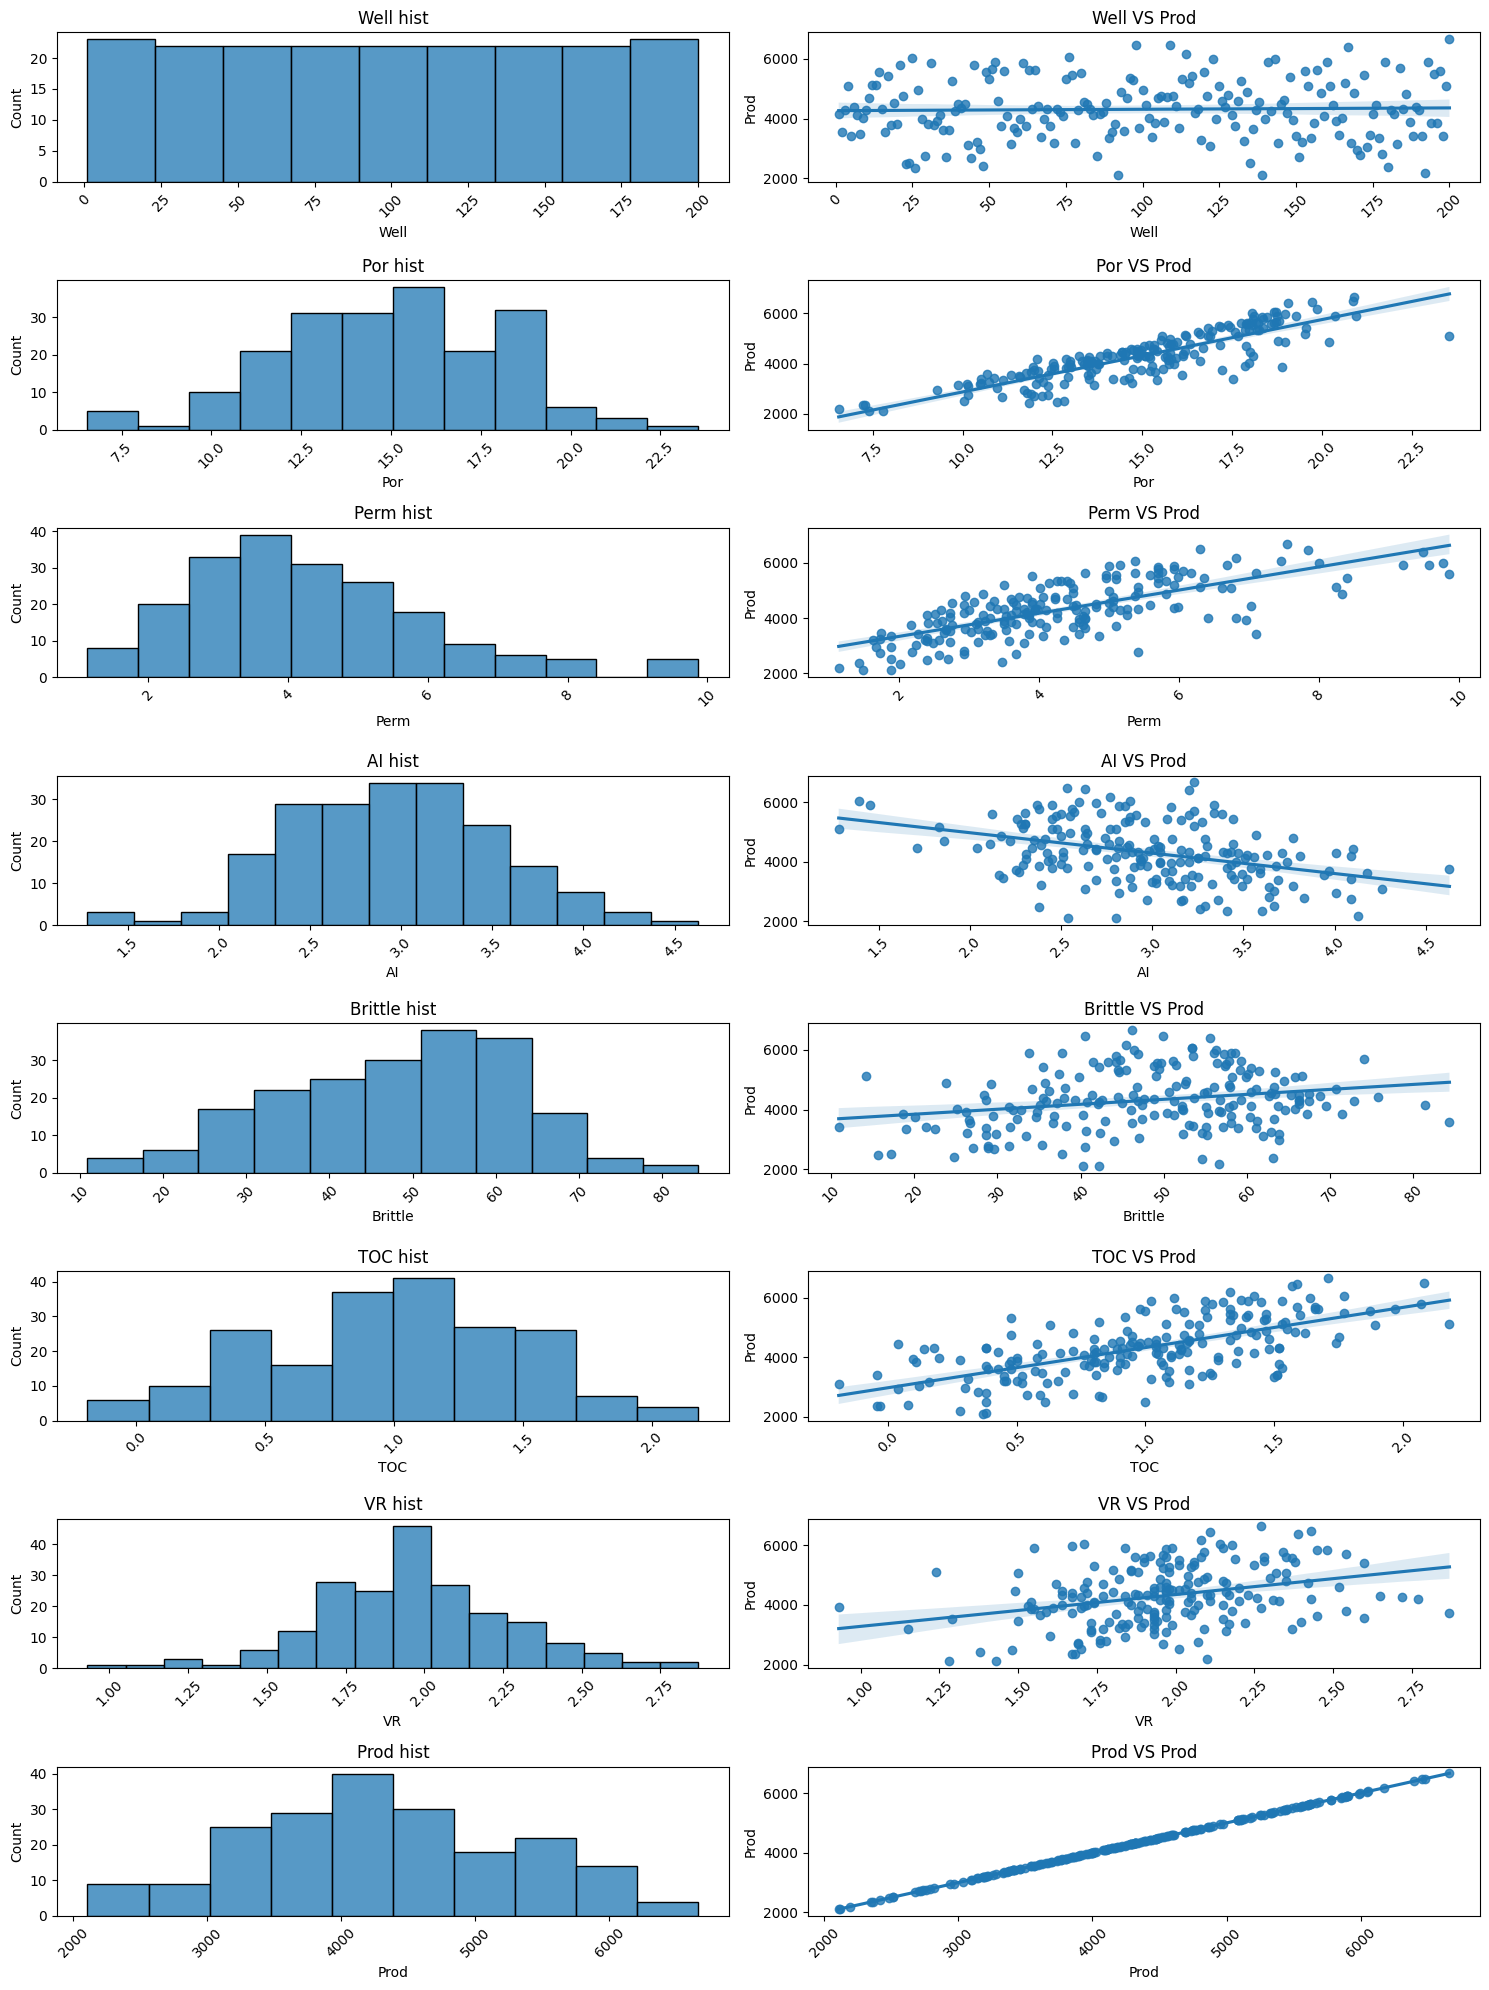

In [5]:
n = len(features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='Prod', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS Prod'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Предварительные выводы.
1. Распределение данных близко к нормальному или логнормальному.
2. Целевая переменная имеет обратную зависимость от признака AI. В остальных случаях зависимость прямая.

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [6]:
# Ваш код здесь
A = data[['Well','Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR', 'Prod']]      # Создаём матрицу
A_cent = A - A.mean()                                                       # Центрируем векторы    
A_st = A_cent/np.linalg.norm(A_cent, axis=0)                                # Проводим нормировку
C = A_st.T @ A_st                                                           # Создаём матрица Грама (корреляций)
C

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
Well,1.000000,0.068927,0.077928,0.041483,-0.079252,0.022624,-0.007279,0.026817
Por,0.068927,1.000000,0.760546,-0.461549,-0.218570,0.711831,0.111860,0.861910
Perm,0.077928,0.760546,1.000000,-0.239636,-0.124017,0.471746,0.051023,0.727426
AI,0.041483,-0.461549,-0.239636,1.000000,0.127599,-0.531864,0.499143,-0.390835
Brittle,-0.079252,-0.218570,-0.124017,0.127599,1.000000,-0.214282,0.317929,0.237155
TOC,0.022624,0.711831,0.471746,-0.531864,-0.214282,1.000000,0.299483,0.654445
VR,-0.007279,0.111860,0.051023,0.499143,0.317929,0.299483,1.000000,0.323182
Prod,0.026817,0.861910,0.727426,-0.390835,0.237155,0.654445,0.323182,1.000000


<AxesSubplot: >

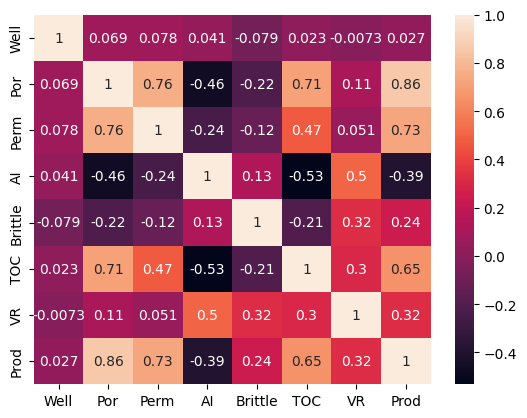

In [7]:
# Визуализируем матрицу корреляций
sns.heatmap( C , annot=True)

In [8]:
print ('Ранг корреляционной матрицы:', np.linalg.matrix_rank(C))
print ('Определитель корреляционной матрицы:', round(np.linalg.det(C) ,4))

Ранг корреляционной матрицы: 8
Определитель корреляционной матрицы: 0.0007


> *Ваши выводы здесь*
1. Корреляционная матрица плохо обусловлена. Её определитеь близок к нулю.
2. Коэффициент корреляции между целевой переменной и признаками Por и Perm (0,86 и 0,73 соответсвенно) что говорит о наличии мультиколиинеарности.
3. Модель классической линейной регрессии по методу наименьших квадратов применима, так как данные отнормированны. Однако мультиколлинеарность усложныет интерпретацию параметров регрессии. 

### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [9]:
# Ваш код здесь
# составляем матрицу наблюдений и вектор целевой переменной
X = np.column_stack((np.ones(200), data[['Well','Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']]))
y = data[['Prod']]
# вычисляем OLS-оценку для коэффициентов без стандартизации
w_hat=np.linalg.inv(X.T@X)@X.T@y
print(w_hat.values)

[[-1.23230803e+03]
 [ 5.07003631e-02]
 [ 2.30179140e+02]
 [ 1.16239006e+02]
 [-3.65202301e+02]
 [ 2.49943700e+01]
 [-7.84009294e+01]
 [ 7.85259815e+02]]


> *Ваши выводы здесь*
1. К неинформативным признакам относится признак "Well", так как его значение составляет сотые доли единицы.
2. Из оставшихся коэффициентов AI и TOC оказывают обратное влияние назначение целевой переменной. 


### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [10]:
# Ваш код здесь
prod = 4748.315024
param_new = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
param = list(map(float, param_new.values()))
param = np.array([[param]])
new_param = np.insert(param, 0, 1)
print('Прогноз:', (new_param@w_hat).values)
print ('Абсоолюная ошибка:', abs((new_param@w_hat).values - prod))


Прогноз: [4723.06405371]
Абсоолюная ошибка: [25.25097029]


In [11]:
mae = 0
mape = 0
predict = np.array([])
for i in range(y.shape[0]):
    mae += abs(float(y.iloc[i]) - float((X[i]@w_hat).values))
    mape += (abs(float(y.iloc[i]) - float((X[i]@w_hat).values)))/abs(float(y.iloc[i])) 
    predict = np.insert(predict, i, float((X[i]@w_hat).values))
mae = mae/y.shape[0]
mape = mape*100/y.shape[0]
print ('Метрика МАЕ:', round(mae, 3))
print ('Метрика МАPЕ:', round(mape, 3))
print ('Прогноз для всей выборки:', predict)

Метрика МАЕ: 153.623
Метрика МАPЕ: 3.628
Прогноз для всей выборки: [4622.70495134 3412.28509773 4717.27342158 5045.93273845 3817.59960464
 4266.59975955 4203.98238154 3385.02513907 4202.93287979 4567.34247328
 4762.32689161 4958.74652566 5376.37329106 5398.87579314 4575.43049238
 3536.30419396 5434.55260889 3963.46242028 4803.20009394 3784.53263333
 5604.88269189 4542.14215288 2558.04389628 2343.05617327 5718.14877932
 2116.77843825 4861.44126248 4169.61525382 2732.36602593 3721.44003237
 5653.63615064 3725.47692036 3923.29152933 4038.39782584 3711.64976655
 2758.56904237 3495.22598653 5428.21355924 4155.15316364 4674.10333006
 4261.05823196 4363.90516919 3096.2697799  2680.51174195 5533.21279385
 3298.17145429 2901.72364441 2405.622932   5222.60246438 5077.32285034
 5341.73544002 5941.43289724 4539.79436263 3858.26792027 5432.62982118
 3991.74414981 3252.50355726 3781.69338147 3662.13468383 4112.86018798
 5792.80295334 3737.23622471 5384.03075658 4364.18989399 5602.08778473
 4377.8690

> *Ваши выводы здесь*

Полученная модель ошибается в среднем на 153 млн. куб. футов или на 3,6 %.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

[[-1.23230803e+03]
 [ 5.07003631e-02]
 [ 2.30179140e+02]
 [ 1.16239006e+02]
 [-3.65202301e+02]
 [ 2.49943700e+01]
 [-7.84009294e+01]
 [ 7.85259815e+02]]


<AxesSubplot: >

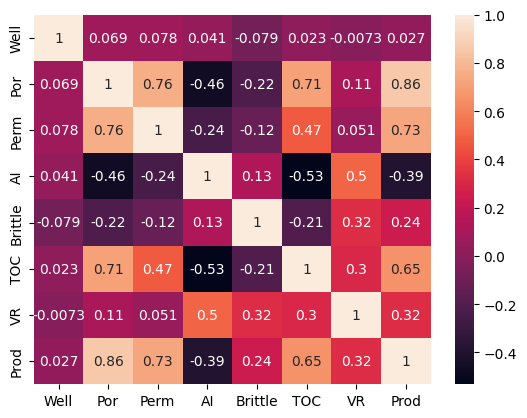

In [12]:
# Ваш код здесь
print(w_hat.values)
sns.heatmap( C , annot=True)

> *Ваши выводы здесь*

Целевой признак и фактор TOC согласно матрицы корреляции имеет прямую зависимость, в то время как вычисленный коэффициент линейной регресии отрицательный, что говорит об обратной зависимости. Это может быть связанно с наличием мультиколлинеарности.  

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

<AxesSubplot: >

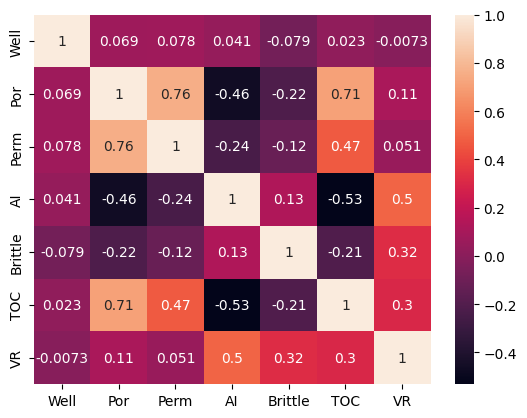

In [13]:
# Ваш код здесь
A_1 = data[['Well','Por', 'Perm', 'AI', 'Brittle', 'TOC', 'VR']]                    # Создаём матрицу корреляции между факторами
A_1_cent = A_1 - A_1.mean()                                                         # Центрируем векторы    
A_st_1 = A_1_cent/np.linalg.norm(A_1_cent, axis=0)                                  # Проводим нормировку
C_1 = A_st_1.T @ A_st_1                                                             # Создаём матрица Грама (корреляций)
sns.heatmap( C_1 , annot=True)

Как следует изматрицы корреляций наиболее сильно связаны между собой факторы 'Por', 'Perm' и 'TOC'. Исключим 'Perm' и 'TOC'. 

In [14]:
X_1 = np.column_stack((np.ones(200), data[['Por','AI', 'Brittle', 'VR']]))  # составляем матрицу наблюдений 
w_hat_1=np.linalg.inv(X_1.T@X_1)@X_1.T@y                                    # вычисляем OLS-оценку для коэффициентов без стандартизации
print(w_hat_1.values)

[[-1835.44646069]
 [  293.03624565]
 [ -200.03091206]
 [   27.64098209]
 [  517.40272597]]


In [15]:
mae_1 = 0
mape_1 = 0
predict_1 = np.array([])
for i in range(y.shape[0]):
    mae_1 += abs(float(y.iloc[i]) - float((X_1[i]@w_hat_1).values))
    mape_1 += (abs(float(y.iloc[i]) - float((X_1[i]@w_hat_1).values)))/abs(float(y.iloc[i]))
    predict_1 = np.insert(predict_1, i, float((X[i]@w_hat).values)) 
mae_1 = mae/y.shape[0]
mape_1 = mape*100/y.shape[0]
print ('Метрика МАЕ:', round(mae_1, 3))
print ('Метрика МАPЕ:', round(mape_1, 1))
print ('Прогноз для всей выборки:', predict_1)

Метрика МАЕ: 0.768
Метрика МАPЕ: 1.8
Прогноз для всей выборки: [4622.70495134 3412.28509773 4717.27342158 5045.93273845 3817.59960464
 4266.59975955 4203.98238154 3385.02513907 4202.93287979 4567.34247328
 4762.32689161 4958.74652566 5376.37329106 5398.87579314 4575.43049238
 3536.30419396 5434.55260889 3963.46242028 4803.20009394 3784.53263333
 5604.88269189 4542.14215288 2558.04389628 2343.05617327 5718.14877932
 2116.77843825 4861.44126248 4169.61525382 2732.36602593 3721.44003237
 5653.63615064 3725.47692036 3923.29152933 4038.39782584 3711.64976655
 2758.56904237 3495.22598653 5428.21355924 4155.15316364 4674.10333006
 4261.05823196 4363.90516919 3096.2697799  2680.51174195 5533.21279385
 3298.17145429 2901.72364441 2405.622932   5222.60246438 5077.32285034
 5341.73544002 5941.43289724 4539.79436263 3858.26792027 5432.62982118
 3991.74414981 3252.50355726 3781.69338147 3662.13468383 4112.86018798
 5792.80295334 3737.23622471 5384.03075658 4364.18989399 5602.08778473
 4377.86905364

> *Ваши выводы здесь*
1. Значения коэффициентов изменились.
2. Противоречие между коэффициентами линейной регрессии и коэффициентами корреляции исчезло.
3. Значения метрик несколько ухудшились.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [16]:
# Ваш код здесь
from sklearn.linear_model import LinearRegression
from sklearn import metrics #метрики
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)
# вычисляем коэффициенты регрессии
model.fit(X_1, y)
y_pred = model.predict(X_1)
print('Метрика MAE: {:.3f}'.format(metrics.mean_absolute_error(y, y_pred)))
print('Метрика MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y, y_pred)*100))

Метрика MAE: 171.431
Метрика MAPE: 4.044


> *Ваши выводы здесь*

Значения метрик полученных с помощью библиотеки `scikit-learn (sklearn)` практически не отличаются от рассчитанных вручную.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


In [17]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [18]:
# Ваш код здесь
from sklearn import preprocessing
A_1 = data[['Por','AI', 'Brittle', 'VR']]
scaler = StandardScaler()
A_scaled = scaler.fit_transform(A_1)

In [19]:
poly = PolynomialFeatures(degree=3, include_bias=True)
A_poly = poly.fit_transform(A_scaled)
display(pd.DataFrame(A_poly))

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1.0,-0.982256,-0.298603,2.358297,1.152048,0.964826,0.293305,-2.316451,-1.131606,0.089164,...,-2.662459e-02,0.210275,0.102721,-1.660701,-0.811267,-0.396311,13.115830,6.407195,3.129970,1.529017
1,1.0,-0.881032,0.444147,-0.141332,-0.280931,0.776218,-0.391308,0.124518,0.247509,0.197266,...,8.761516e-02,-0.027880,-0.055418,0.008872,0.017635,0.035053,-0.002823,-0.005612,-0.011154,-0.022172
2,1.0,-0.327677,1.841224,1.748113,2.518377,0.107372,-0.603327,-0.572817,-0.825215,3.390105,...,6.241941e+00,5.926284,8.537563,5.626591,8.105816,11.677454,5.342052,7.695903,11.086922,15.972114
3,1.0,0.903875,-0.599240,-0.592585,-0.280931,0.816990,-0.541638,-0.535623,-0.253926,0.359088,...,-2.151801e-01,-0.212791,-0.100879,-0.210428,-0.099759,-0.047293,-0.208091,-0.098651,-0.046768,-0.022172
4,1.0,0.853263,0.373409,-2.640962,-0.214280,0.728058,0.318616,-2.253436,-0.182838,0.139434,...,5.206585e-02,-0.368240,-0.029878,2.604406,0.211314,0.017145,-18.419868,-1.494537,-0.121263,-0.009839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.0,-1.026119,0.002034,1.349364,0.318921,1.052921,-0.002087,-1.384608,-0.327251,0.000004,...,8.411496e-09,0.000006,0.000001,0.003703,0.000875,0.000207,2.456898,0.580686,0.137245,0.032438
196,1.0,1.011847,0.727099,-0.272593,0.385571,1.023834,0.735713,-0.275822,0.390139,0.528673,...,3.843976e-01,-0.144113,0.203841,0.054029,-0.076421,0.108094,-0.020256,0.028651,-0.040525,0.057321
197,1.0,-0.968759,0.974682,0.632042,-0.780807,0.938495,-0.944233,-0.612296,0.756414,0.950005,...,9.259535e-01,0.600443,-0.741771,0.389363,-0.481008,0.594224,0.252486,-0.311914,0.385330,-0.476026
198,1.0,0.188562,-0.864508,0.715765,1.285349,0.035556,-0.163014,0.134966,0.242369,0.747374,...,-6.461102e-01,0.534944,0.960636,-0.442904,-0.795353,-1.428272,0.366700,0.658509,1.182530,2.123553


In [20]:
lr = LinearRegression().fit(A_poly, y)
y_pred = lr.predict(A_poly)

In [21]:
cv_results = cross_validate(lr, A_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

MAPE на тренировочных фолдах: 5.21 %
MAPE на валидационных фолдах: 6.68 %


> *Ваши выводы здесь*

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [22]:
# Ваш код здесь

from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {
               'alpha': list(np.linspace(1, 10, 10, dtype=float))},
            
random_search_l = RandomizedSearchCV(
    estimator=linear_model.Lasso(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_l.fit(A_poly, y) 
print("Наилучшие значения гиперпараметров: {}".format(random_search_l.best_params_))
lasso = Lasso(alpha=6.0, max_iter=10000)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, A_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))


CPU times: total: 156 ms
Wall time: 2.96 s
Наилучшие значения гиперпараметров: {'alpha': 6.0}
MAPE на тренировочных фолдах: 1.85 %
MAPE на валидационных фолдах: 2.28 %


> *Ваши выводы здесь*

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

In [23]:
# Ваш код здесь
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {
               'alpha': list(np.linspace(1, 10, 10, dtype=float))},
            
random_search_r = RandomizedSearchCV(
    estimator=linear_model.Ridge(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_r.fit(A_poly, y) 
##print("accuracy на тестовом наборе: {:.2f}".format(random_search.mean_absolute_percentage_error(A_poly, y)))
#y_test_pred = random_search.predict(A_poly)
#print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_r.best_params_))
ridge = Ridge(alpha=1, solver='svd')
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(ridge, A_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100))

CPU times: total: 78.1 ms
Wall time: 51 ms
Наилучшие значения гиперпараметров: {'alpha': 1.0}
MAPE на тренировочных фолдах: 1.83 %
MAPE на валидационных фолдах: 2.72 %


> *Ваши выводы здесь*

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [24]:
# Ваш код здесь
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {
               'alpha': list(np.linspace(1, 10, 10, dtype=float)),
               'l1_ratio': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search_e = RandomizedSearchCV(
    estimator=linear_model.ElasticNet(random_state=42, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_e.fit(A_poly, y) 
print("Наилучшие значения гиперпараметров: {}".format(random_search_e.best_params_))


CPU times: total: 78.1 ms
Wall time: 54 ms
Наилучшие значения гиперпараметров: {'l1_ratio': 1.0, 'alpha': 10.0}


In [25]:
lasso = ElasticNet(alpha=random_search_e.best_params_['alpha'], l1_ratio=random_search_e.best_params_['l1_ratio'], max_iter=10000)
# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, A_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.2f} %'.format(-cv_results['train_score'].mean()* 100))
print('MAPE на валидационных фолдах: {:.2f} %'.format(-cv_results['test_score'].mean() * 100)) 

MAPE на тренировочных фолдах: 1.95 %
MAPE на валидационных фолдах: 2.38 %


> *Ваши выводы здесь*

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [26]:
# Ваш код здесь

> *Ваши выводы здесь*

In [27]:
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

In [28]:
space={'alpha': hp.quniform('alpha', 1, 10, 10)}

In [31]:
random_state = 42
def hyperopt_rf(params, cv=5, X=A_poly, y = y, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'alpha': int(params['alpha'])}
  
    # используем эту комбинацию для построения модели
    model = linear_model.Lasso(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.mean_absolute_percentage_error(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [34]:
%%time
trials = Trials() # используется для логирования результатов
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:00<00:00, 173.87trial/s, best loss: -0.019760972146603592]
Наилучшие значения гиперпараметров {'alpha': 10.0}
CPU times: total: 125 ms
Wall time: 118 ms


C:\Users\Vladimir\AppData\Local\Temp\ipykernel_12572\498973172.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X, y)

c:\Users\Vladimir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(

c:\Users\Vladimir\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+06, tolerance: 1.958e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeC